In [ ]:
import pandas as pd
import os

# Step 1: Read the CSV file into a DataFrame in chunks
data_chunks = pd.read_csv('moses.csv', chunksize=5000)

# Step 2: Process each chunk and save to separate CSV files
processed_files = []

for i, chunk in enumerate(data_chunks):
    # Drop the second column ('SPLIT')
    chunk.drop(columns=['SPLIT'], inplace=True)
    
    # Remove duplicates and null values
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    
    # Save the processed chunk to a separate CSV file
    processed_file = f'processed_chunk_{i}.csv'
    chunk.to_csv(processed_file, index=False)
    
    processed_files.append(processed_file)

# Step 3: Concatenate the processed chunks into a single DataFrame
final_result = pd.concat([pd.read_csv(file) for file in processed_files], ignore_index=True)

# Step 4: Drop duplicates from the final result
final_result.drop_duplicates(inplace=True)

# Step 5: Save the final result to a CSV file
final_result.to_csv('moses_processed.csv', index=False)

# Step 6: Delete the individual processed chunk files
for file in processed_files:
    os.remove(file)


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import os

# Step 1: Read the processed CSV file into a DataFrame in chunks
data_chunks = pd.read_csv('moses_processed.csv', chunksize=5000)

# Step 2: Initialize a counter for tracking the processed chunks
processed_chunks_count = 0

# Step 3: Function to calculate Morgan fingerprints for a chunk and save to CSV
def calculate_fingerprints(chunk, chunk_index):
    # Convert SMILES to RDKit Mol objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in chunk['SMILES']]
    
    # Calculate Morgan fingerprints
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, 2048) for mol in mols]
    
    # Initialize an empty list to store fingerprint data
    fps_data = []
    
    # Iterate over each fingerprint
    for fp in fps:
        # Convert fingerprint object to binary string and split it into individual bits
        bits = [int(bit) for bit in fp.ToBitString()]
        # Append the bits to the fps_data list
        fps_data.append(bits)
    
    # Create a DataFrame with the fingerprint data
    fp_df = pd.DataFrame(fps_data, columns=[f'Bit{i}' for i in range(2048)])
    
    # Concatenate the original data with the fingerprint DataFrame
    result = pd.concat([chunk.reset_index(drop=True), fp_df], axis=1)
    
    # Save the processed chunk with fingerprints to a separate CSV file
    processed_file = f'processed_chunk_with_fingerprints_{chunk_index}.csv'
    result.to_csv(processed_file, index=False)
    
    return processed_file

# Step 4: Process chunks and calculate fingerprints
processed_files = []

for i, chunk in enumerate(data_chunks):
    processed_file = calculate_fingerprints(chunk, i)
    processed_files.append(processed_file)
    processed_chunks_count += 1
    print(f'Processed chunk {processed_chunks_count} saved to {processed_file}')


In [ ]:
import pandas as pd
import os

# List all CSV files in the directory
csv_files = [file for file in os.listdir() if file.startswith('processed_chunk_with_fingerprint')]

# Name for the final merged CSV file
final_csv_file = 'merged_moses_with_fingerprints.csv'

# Check if the final CSV file already exists
if os.path.exists(final_csv_file):
    os.remove(final_csv_file)

# Open the final CSV file in append mode
with open(final_csv_file, 'a') as final_csv:
    # Iterate over each CSV file
    for file in csv_files:
        # Open and read each CSV file chunk by chunk
        for chunk in pd.read_csv(file, chunksize=10000):  # Adjust chunksize as needed
            # Write the chunk to the final CSV file without header after the first chunk
            chunk.to_csv(final_csv, index=False, header=not os.path.exists(final_csv_file))

        # Optionally, delete the individual file to free up memory
        os.remove(file)
        print(f"Processed and removed: {file}")

print("All files merged and saved.")


In [2]:
import dask.dataframe as dd

In [1]:
import pandas as pd
import dask.dataframe as dd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import tempfile
import os

# Step 1: Read the merged CSV file using Dask
ddf = dd.read_csv('merged_moses_with_fingerprints.csv', header=None, usecols=[0] + list(range(3, 203)), dtype={0: 'str'})

# Step 2: Apply PCA for dimensionality reduction
n_components = 100
pca = PCA(n_components=n_components, random_state=42)

# Step 3: Apply KMeans clustering
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Step 4: Apply PCA and KMeans clustering using Dask
features = ddf.iloc[:, 1:].to_dask_array(lengths=True)
features_reduced = pca.fit_transform(features)
cluster_labels = kmeans.fit_predict(features_reduced)






/home/parth/miniconda3/envs/ML_QSAR/lib/python3.8/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/parth/miniconda3/envs/ML_QSAR/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [2]:
# Convert Dask DataFrame to pandas DataFrame
df = ddf.compute()

# Step 5: Extract 10 molecules from each cluster
cluster_molecules = {}

for i in range(n_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    
    if len(cluster_indices) > 10:
        random_indices = np.random.choice(cluster_indices, 10, replace=False)
        smiles = df.iloc[random_indices.tolist(), 0].values
        cluster_molecules[i] = smiles.tolist()
    else:
        smiles = df.iloc[cluster_indices.tolist(), 0].values
        cluster_molecules[i] = smiles.tolist()




In [3]:
# Step 6: Create a DataFrame to store the results
results = []

for cluster, smiles_list in cluster_molecules.items():
    for smiles in smiles_list:
        results.append({'SMILES': smiles, 'Cluster': cluster})

results_df = pd.DataFrame(results)

# Step 7: Save the results to a CSV file
results_df.to_csv('clustered_molecules.csv', index=False)

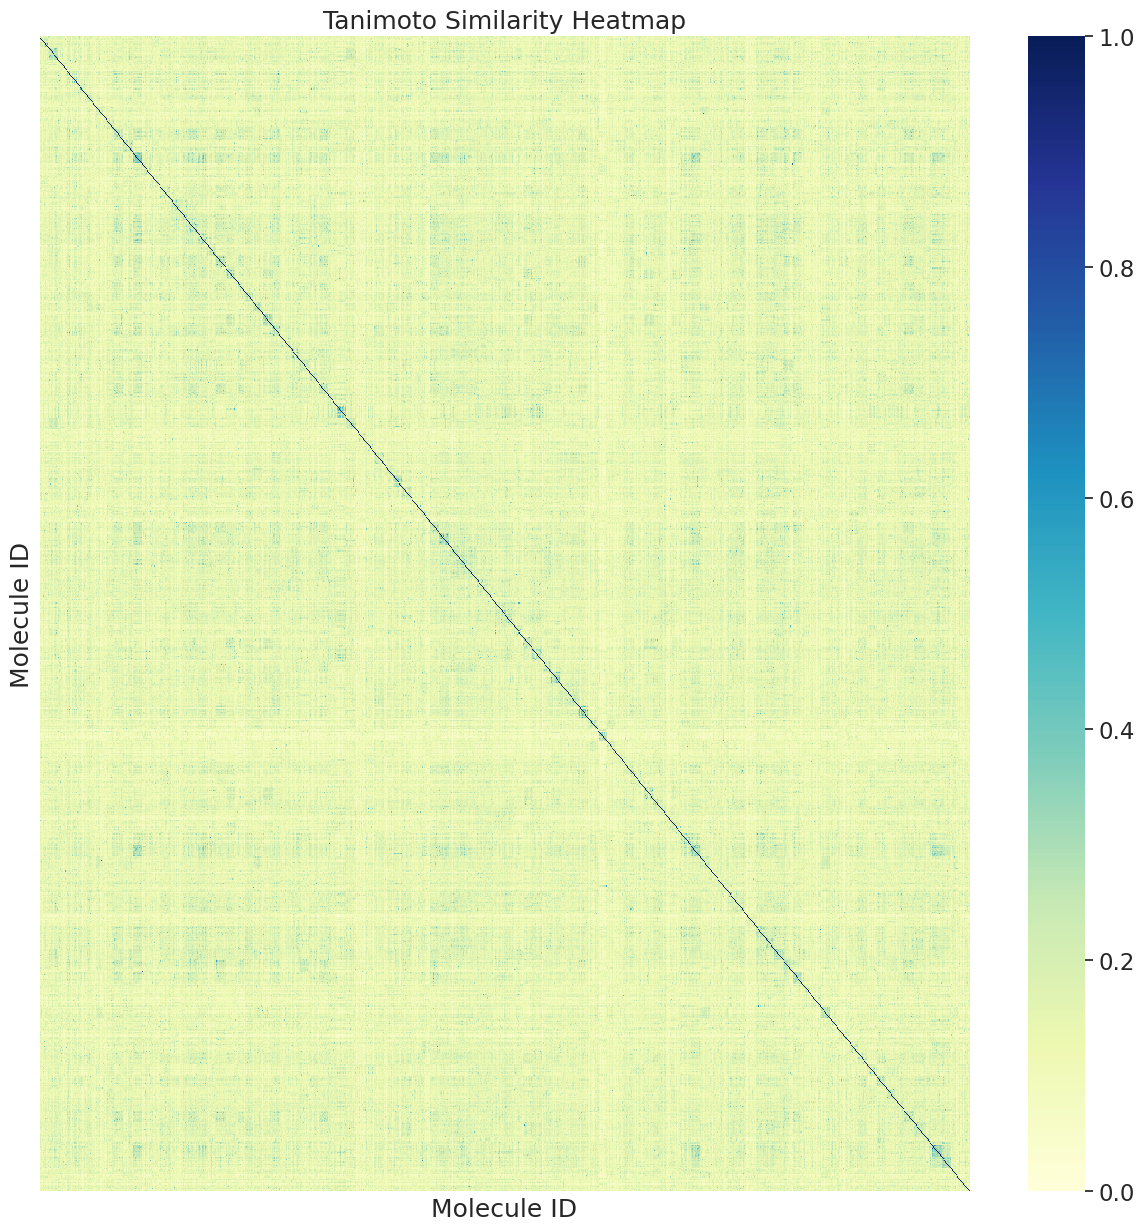

In [4]:
import pandas as pd
from rdkit import DataStructs
from rdkit.Chem import AllChem
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Read the CSV
df = pd.read_csv('clustered_molecules.csv')

# Step 2: Compute Tanimoto similarity matrix
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(AllChem.MolFromSmiles(smiles), 2, nBits=1024) for smiles in df['SMILES']]
similarity_matrix = []
for i in range(len(fingerprints)):
    similarities = [DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j]) for j in range(len(fingerprints))]
    similarity_matrix.append(similarities)

# Step 3: Plot the heatmap
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 15))
sns.heatmap(similarity_matrix, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.title('Tanimoto Similarity Heatmap')
plt.xlabel('Molecule ID')
plt.ylabel('Molecule ID')
plt.show()
